In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

import sys
sys.path.append("../")
import mymodule2 as mm
from exp_guitare_configs import *

from data_loader import *

%matplotlib widget

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (12,4)

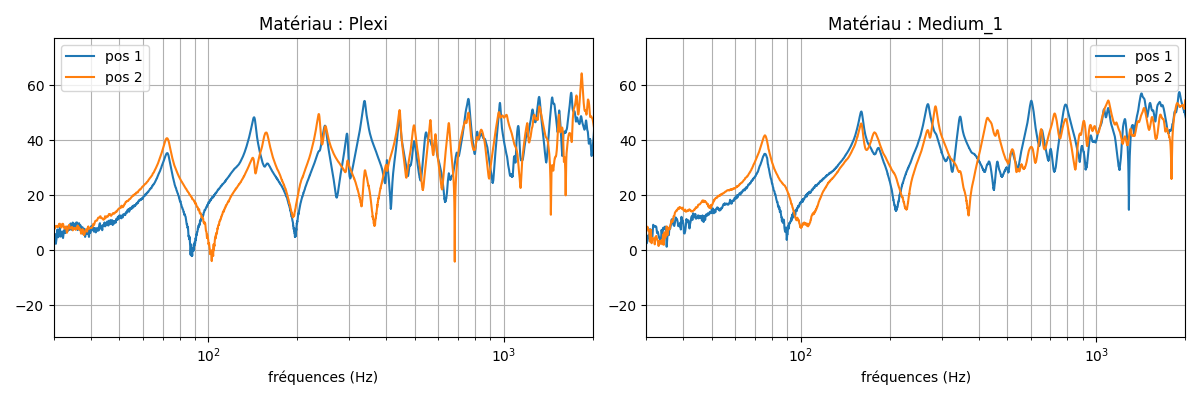

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.semilogx(deforme_Nta_Npos[2,0]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[2,0]["FRF"])),label="pos 1")
ax1.semilogx(deforme_Nta_Npos[2,1]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[2,1]["FRF"])),label="pos 2")
ax1.grid(which="both")
ax1.set_title(f"Matériau : {deforme_Nta_Npos[2,0]['mat_table']}")
ax1.set_ylabel("")
ax1.set_xlabel("fréquences (Hz)")
ax1.legend()
ax1.set_xlim(30,2000)
ylims = ax1.set_ylim()

ax2.semilogx(deforme_Nta_Npos[1,0]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[1,0]["FRF"])),label="pos 1")
ax2.semilogx(deforme_Nta_Npos[1,1]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[1,1]["FRF"])),label="pos 2")
ax2.grid(which="both")
ax2.set_title(f"Matériau : {deforme_Nta_Npos[1,0]['mat_table']}")
ax2.set_ylabel("")
ax2.set_xlabel("fréquences (Hz)")
ax2.legend()
ax2.set_xlim(30,2000)
ax2.set_ylim(ylims)

fig.tight_layout()

plt.show()

In [3]:
def plot_frfs_mat(idx_mat) :
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.semilogx(deforme_Nta_Npos[idx_mat,0]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[idx_mat,0]["FRF"])),label="pos 1")
    ax1.semilogx(deforme_Nta_Npos[idx_mat,1]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[idx_mat,1]["FRF"])),label="pos 2")
    ax1.grid(which="both")
    ax1.set_title(f"Matériau : {deforme_Nta_Npos[idx_mat,0]['mat_table']}")
    ax1.set_ylabel("")
    ax1.set_xlabel("Fréquences $(Hz)$")
    ax1.legend()
    ax1.set_xlim(30,2000)
    ylims = ax1.set_ylim()

    import matplotlib.ticker as mticker
    ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())

    fig.tight_layout()

    plt.show()

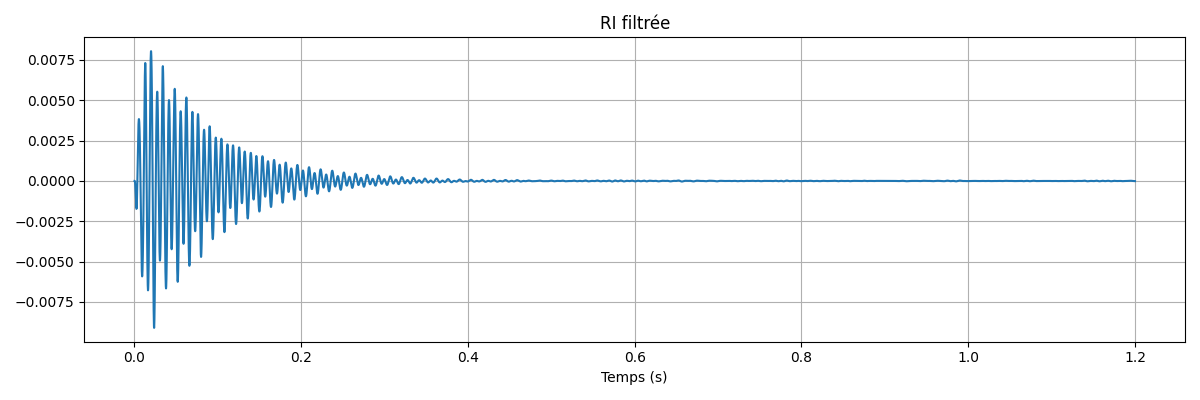

In [4]:
idx_mat = 3

RI = deforme_Nta_Npos[idx_mat, 0]["RI"]
fs = deforme_Nta_Npos[idx_mat, 0]["fs"]
tRI = np.arange(len(RI))/fs

# tRI, RI = mm.clean_RI(RI, fs, method="max", cut_end=1.2)

RI_filtered = mm.bandpass_filter(RI,30, 150, fs, order=50)

plot = True
if plot :
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    # ax1.plot(tRI,RI,label="")
    ax1.plot(mm.time_vector(RI_filtered,fs),RI_filtered,label="")
    ax1.grid()
    #ax1.legend()
    ax1.set_xlabel("Temps (s)")
    ax1.set_ylabel("")
    ax1.set_title(r"RI filtrée")
    ax1.set_xlim()
    ax1.set_ylim()

    fig.tight_layout()

    plt.show()

In [5]:
def esprit_on_band(RI, fs, lowcut, highcut, poles, order=5, len_esprit=512*7, plot_result=False, number_of_max = 4, Nfft=100000) :
    """
    Cette fonction utilise l'algorithme ESPRIT sur une bande de fréquence particulière.
    Il calcul aussi la réponse en fréquence, et les amplitudes de cette réponses aux fréquence trouvées par ESPRIT.

    ## Inputs
    - `RI` : réponse impulsionnelle d'entrée
    - `fs` : fréquence d'échantillonnage
    - `lowcut` : fréquence de coupure basse du filtre à appliquer
    - `highcut` : fréquence de coupure haute du filtre à appliquer
    - `poles` : nombre de pôles calculés par ESPRIT
    - `order` : ordre du filtre butterworth utilisé
    - `len_esprit` : longueur de la portion ud signal donnée à ESPRIT
    - `plot_result` : trace la réponse en fréquence avec les fréquences trouvées par ESPRIT si `True`
    - `Nfft` : nombre de points pour la FFT

    ## Outputs
    - `freq_amp_sorted` : arrayLike, liste des fréquences trouvées par ESPRIT de taille `number_of_max`, triées par amplitude de la FRF de la plus grande à la plus petite.
    - `delta_amp_sorted` : arrayLike, liste des amortissements trouvées par ESPRIT de taille `number_of_max`, triées par amplitude de la FRF de la plus grande à la plus petite.
    """

    RI_filtered = mm.bandpass_filter(RI, lowcut, highcut, fs, order=order)
    fk, deltak = mm.ESPRIT(RI_filtered[512:len_esprit], len_esprit//2, poles, return_pos=True)

    Y = np.fft.rfft(RI_filtered, Nfft)
    fy = np.fft.rfftfreq(Nfft,1/fs)

    #Calcul des amplitudes de la réponse en fréquences aux fréquences trouvées par ESPRIT
    amp = np.zeros(len(fk))
    for i in range(len(fk)) :
        fk_idx = mm.find_nearest_index(fy, fk[i]*fs)
        amp[i] = 20*np.log10(np.abs(Y[fk_idx]))
    freq_amp_sorted = fk[amp.argsort()[-number_of_max:][::-1]]*fs
    delta_amp_sorted = deltak[amp.argsort()[-number_of_max:][::-1]]

    if plot_result :
        fig = plt.figure()
        ax1 = fig.add_subplot(111)


        ax1.semilogx(fy,20*np.log10(np.abs(Y)),label="")
        ax1.grid(which="both")
        #ax1.legend()
        ax1.set_xlabel("Fréquences $(Hz)$")
        ax1.set_ylabel("FFT $(dB)$")
        ax1.set_title(r"Réponse en fréquence filtrée, superposée à ESPRIT")
        ax1.set_xlim(30,2000)
        ylims = ax1.set_ylim()
        ax1.vlines(fk*fs, ylims[0], ylims[1], alpha=0.4, color="black", ls="--")

        import matplotlib.ticker as mticker
        ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
        
        fig.tight_layout()

        plt.show()

    return freq_amp_sorted, delta_amp_sorted
    

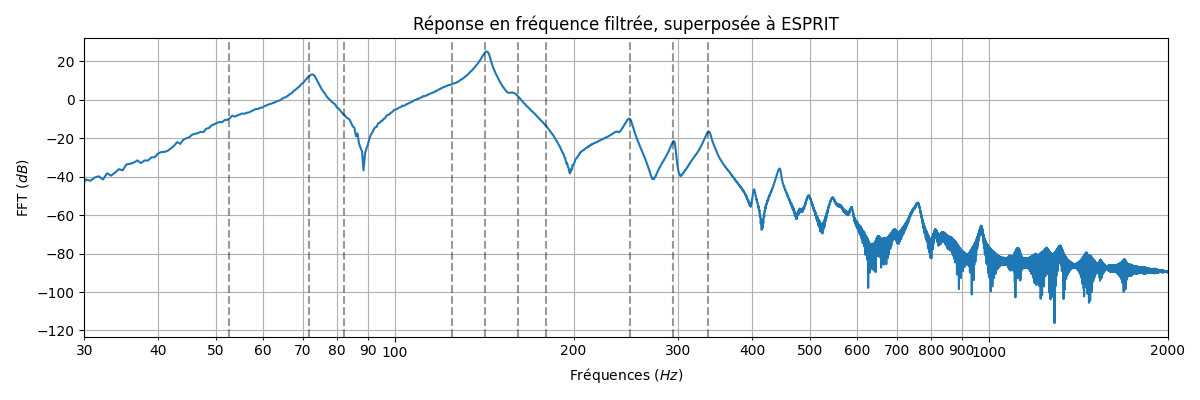

(array([142.00928046,  71.83275343, 125.02954458, 161.3092357 ,
         81.98120254,  52.48538645]),
 array([-0.00019024, -0.00015137, -0.00278153, -0.00024048, -0.00299443,
        -0.00063982]))

In [6]:
esprit_on_band(RI, fs, 48, 150, order=50, plot_result=True, poles=20, number_of_max=6)

# Analyse des tables : protocole

- Choisir un indice de matériau $i_m$ entre les 4 indices [0,1,2,3].
- Tracer la réponse en fréquence pour les 2 positions de frappe avec `plot_frfs_mat(idx_mat)` : l'idée est d'observer à la main où sont les pics en fréquences.
- Accéder aux réponses impulsionnelle avec `deforme_Nta_Npos[idx_mat, 0]`, `deforme_Nta_Npos[idx_mat, 1]`.
- Sélectionner à l'oeil une bande de fréquence où il y a un ou plusieurs pics, et utiliser `esprit_on_band()` pour appliquer esprit sur cette bande de fréquence.
- Sélectionner les fréquences cohérentes avec les pics, et les amortissements, à noter quelque part.
- Faire cela pour une vingtaine de mode par plaque.